In [1]:
import numpy as np
import pandas as pd

# Модель для прогнозирования, например ARIMA
from sktime.forecasting.arch import ARCH
# Визуализация временных рядов
from sktime.utils.plotting import plot_series
# Модули для кросс-валидации
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter, SlidingWindowSplitter, SingleWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError # Метрики MSE, MAE, MAPE

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [2]:
m2 = web.DataReader(name='WM2NS', data_source='fred', start='1995-01-01')
y = np.log(m2).diff().dropna() #лог доходность #dropna сбрасывает нулевые значения чтобы было без ошибок

In [3]:
y.shape

(1574, 1)

In [6]:
# Зададим список из специфицированных моделей прогнозирования
forecasters = [ARCH(mean='AR', lags=1, vol='GARCH', p=1, q=1, power=2), ARCH(mean='AR', lags=1, vol='GARCH', p=1, q=1, o=1, power=2), 
               ARCH(mean='AR', lags=1, vol='EGARCH', p=1, q=1), ARCH(mean='AR', lags=1, vol='EGARCH', p=1, q=1, o=1),
              ARCH(mean='AR', lags=1, vol='APARCH', p=1, q=1, power=2),
              ARCH(mean='AR', lags=2, vol='GARCH', p=1, q=1, power=2), ARCH(mean='AR', lags=2, vol='GARCH', p=1, q=1, o=1, power=2), 
               ARCH(mean='AR', lags=2, vol='EGARCH', p=1, q=1), ARCH(mean='AR', lags=2, vol='EGARCH', p=1, q=1, o=1),
              ARCH(mean='AR', lags=2, vol='APARCH', p=1, q=1, power=2)]
# специфицируем метод кросс-валидации. Например, SlidingWindowSplitter
cv_strategy = SlidingWindowSplitter(fh=np.arange(1, 6), initial_window=300, step_length=10)

# инициализируем метрики
metric = [MeanSquaredError(square_root=False), MeanAbsoluteError(), MeanAbsolutePercentageError()]

# датафрейм с метриками по столбцам
cv_data = pd.DataFrame(data=None, columns=['MSE', 'MAE', 'MAPE'])

for model in forecasters:
	print(model)
	cv_res = evaluate(forecaster=model, y=y, cv=cv_strategy, strategy="refit", return_data=False, scoring=metric)
	# print(df.iloc[:,:len(metric)].mean()) # метрики для каждой модели
	cv_data.loc[len(cv_data.index)] = cv_res.iloc[:,[0,1,2]].mean().values

# результаты кросс-валидации в виде датафрейма
cv_data

ARCH(lags=1, mean='AR', power=2)
ARCH(lags=1, mean='AR', o=1, power=2)
ARCH(lags=1, mean='AR', vol='EGARCH')
ARCH(lags=1, mean='AR', o=1, vol='EGARCH')
ARCH(lags=1, mean='AR', power=2, vol='APARCH')
ARCH(lags=2, mean='AR', power=2)
ARCH(lags=2, mean='AR', o=1, power=2)
ARCH(lags=2, mean='AR', vol='EGARCH')
ARCH(lags=2, mean='AR', o=1, vol='EGARCH')
ARCH(lags=2, mean='AR', power=2, vol='APARCH')


,MSE,MAE,MAPE
0,3.758600e-05,4.490058e-03,2.184690e+00
1,4.475315e+01,3.121255e-01,1.175449e+02
2,6.259924e+41,3.613931e+19,4.784396e+23
3,9.507752e+42,1.711746e+20,1.910537e+23
4,3.722294e-05,4.465362e-03,2.215068e+00
5,4.510696e-05,4.868701e-03,2.945328e+00
6,4.631155e-05,4.919395e-03,2.952405e+00
7,1.279381e+54,4.530268e+25,1.055424e+28
8,3.380072e+38,7.296279e+17,2.377673e+20
9,1.796449e+05,1.898913e+01,4.226826e+03


In [7]:
# Индекс модели
for i in range(cv_data.shape[1]):
	print(f'{cv_data.columns[i]}: model #={cv_data.iloc[:,i].argmin()}')

MSE: model #=4
MAE: model #=4
MAPE: model #=0


<Axes: xlabel='DATE'>

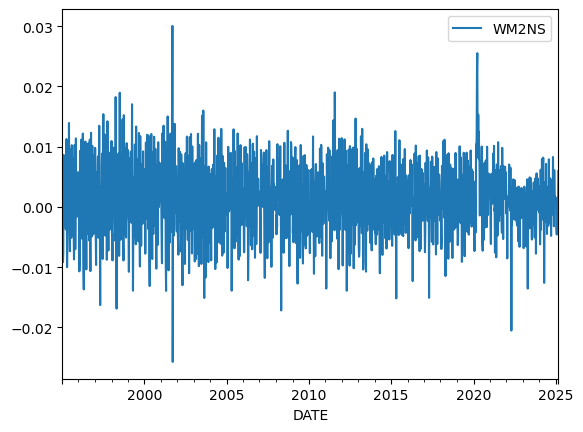

In [8]:
y.plot()